### Import Packages

In [466]:
# Data Processing
import pandas as pd
import numpy as np
pd.options.display.max_rows= 999

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
 

# ML Tools
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score

# ML Models
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import xgboost as xgb
from lightgbm import LGBMRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

import shap

### Import Files

In [467]:
train_df= pd.read_csv("train.csv")
test_df= pd.read_csv("test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.sample(10)

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
790,791,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,160200
566,567,60,RL,77.0,11198,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,325000
1246,1247,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2006,New,Partial,186500
1011,1012,90,RL,75.0,9825,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,100000
937,938,60,RL,75.0,9675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,253000
593,594,120,RM,NaN,4435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,140000
325,326,45,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,87000
358,359,80,RL,92.0,6930,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,130000
912,913,30,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,620,7,2006,WD,Abnorml,88000
394,395,50,RL,60.0,10134,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,109000


### Model Evaluation Prep

In [468]:
# Target Variable
# y=train_df['SalePrice']

# Test Id for Kaggle Submission
test_id= test_df['Id']

## EDA

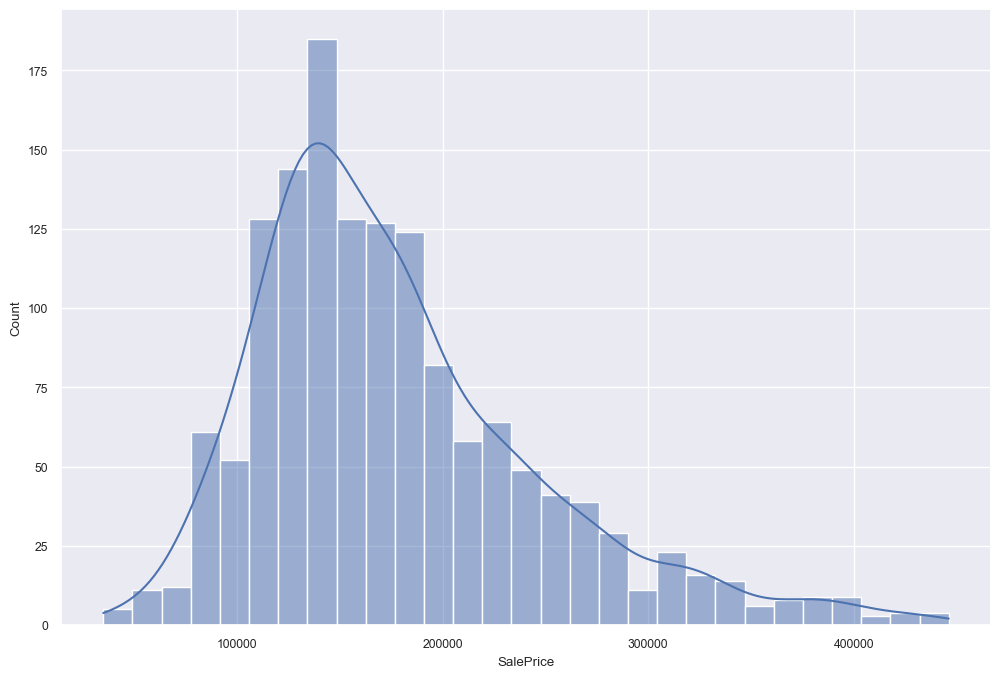

In [469]:
# Target Variable Distribution
plt.figure(figsize = [12,8])
sns.histplot(data=y, kde= True)
plt.show()

In [470]:
fig = px.box(y)
fig.update_layout(xaxis_title='', yaxis_title='Price', title='Identify Outliers Using Box Plot')

# Show the plot
fig.show()

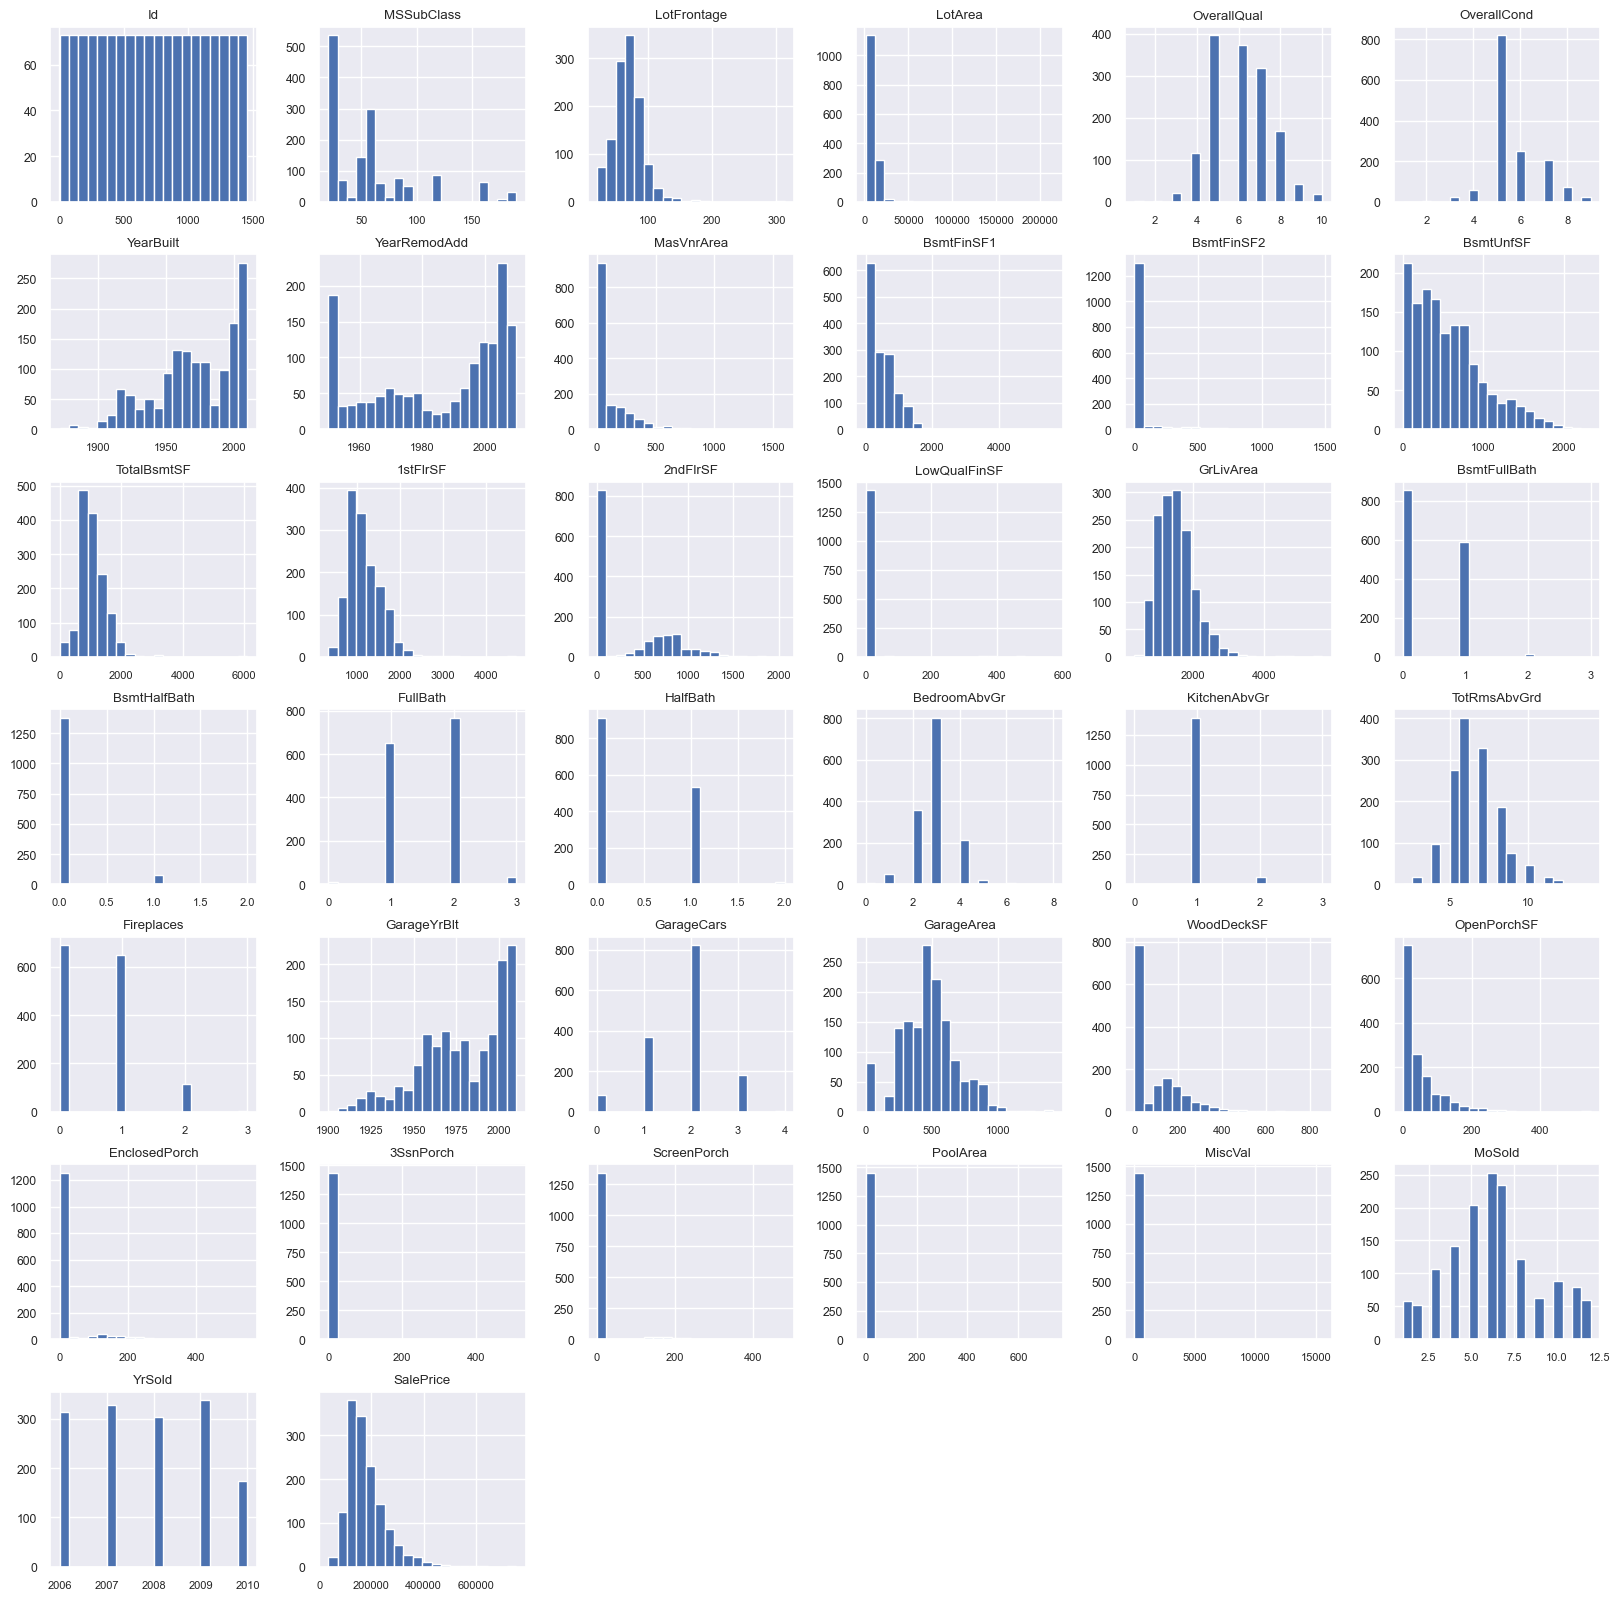

In [471]:
# View Data Distribution
df_num= train_df.select_dtypes(include = ['float64', 'int64'])

df_num.hist(figsize=(20, 20), bins=20, xlabelsize=8)
plt.show()

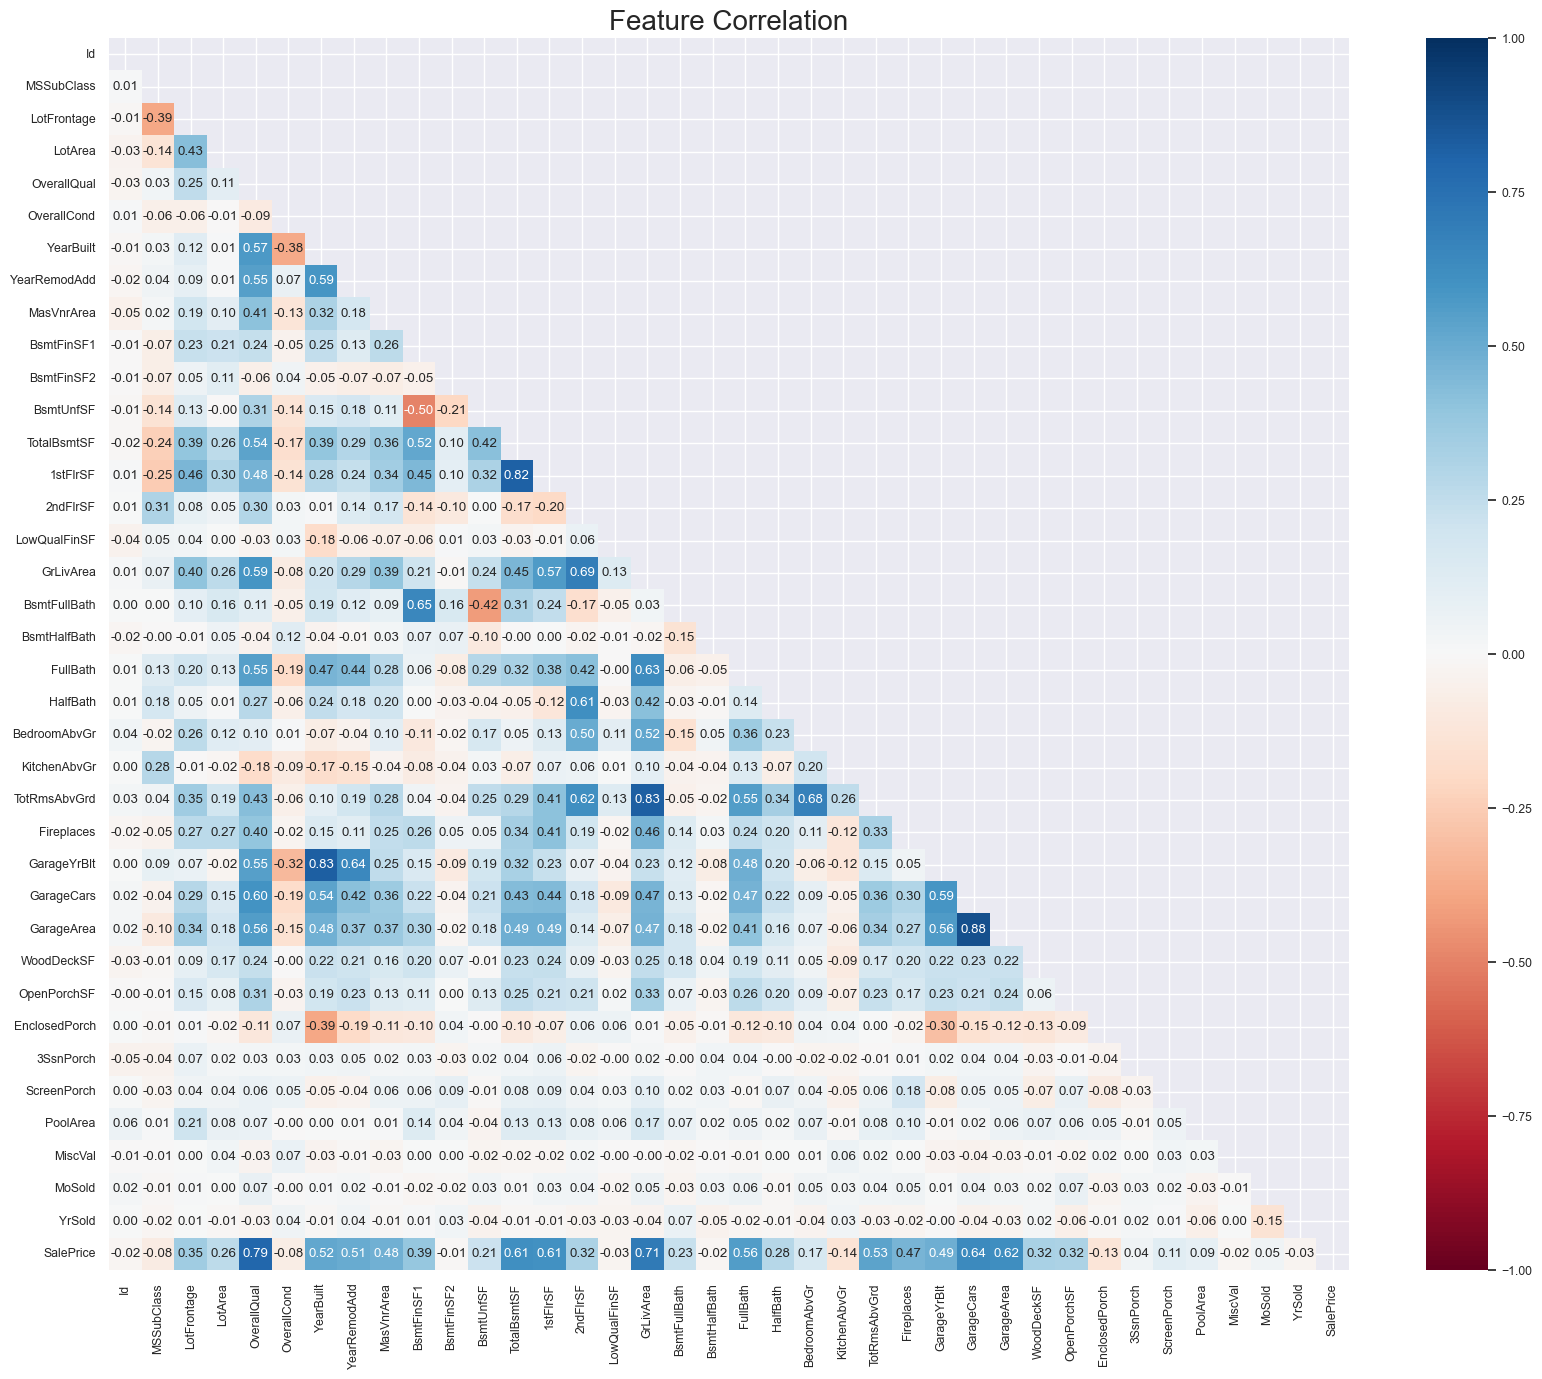

In [472]:
# Set Figure Format
plt.figure(figsize=(20,16))
sns.set(font_scale=0.8)
plt.title('Feature Correlation', fontsize=20)

# Show only upper correlation
mask = np.triu(np.ones_like(df_num.corr()))
sns.heatmap(df_num.corr(), annot= True, mask=mask, fmt='.2f', cmap="RdBu",vmin=-1, vmax=1)

plt.show()

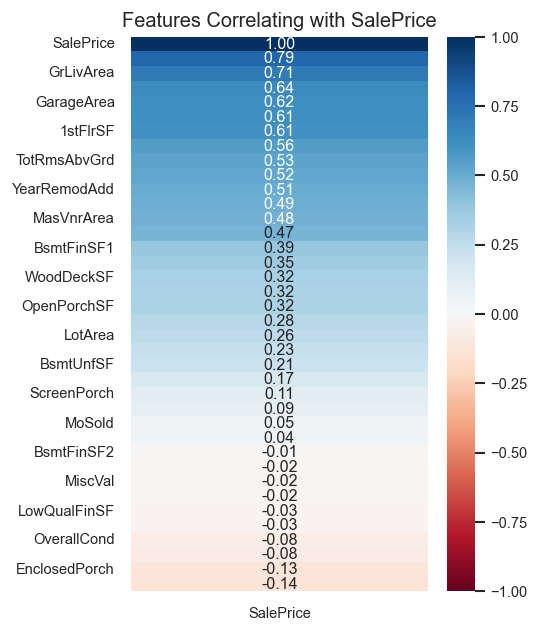

In [473]:
# Set Figure Format
plt.figure(figsize=(4, 6), dpi=120)

# Show correlation with SalePrice
heatmap = sns.heatmap(df_num.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, fmt='.2f', cmap="RdBu",vmin=-1, vmax=1)
heatmap.set_title('Features Correlating with SalePrice', fontsize=12)

plt.show()

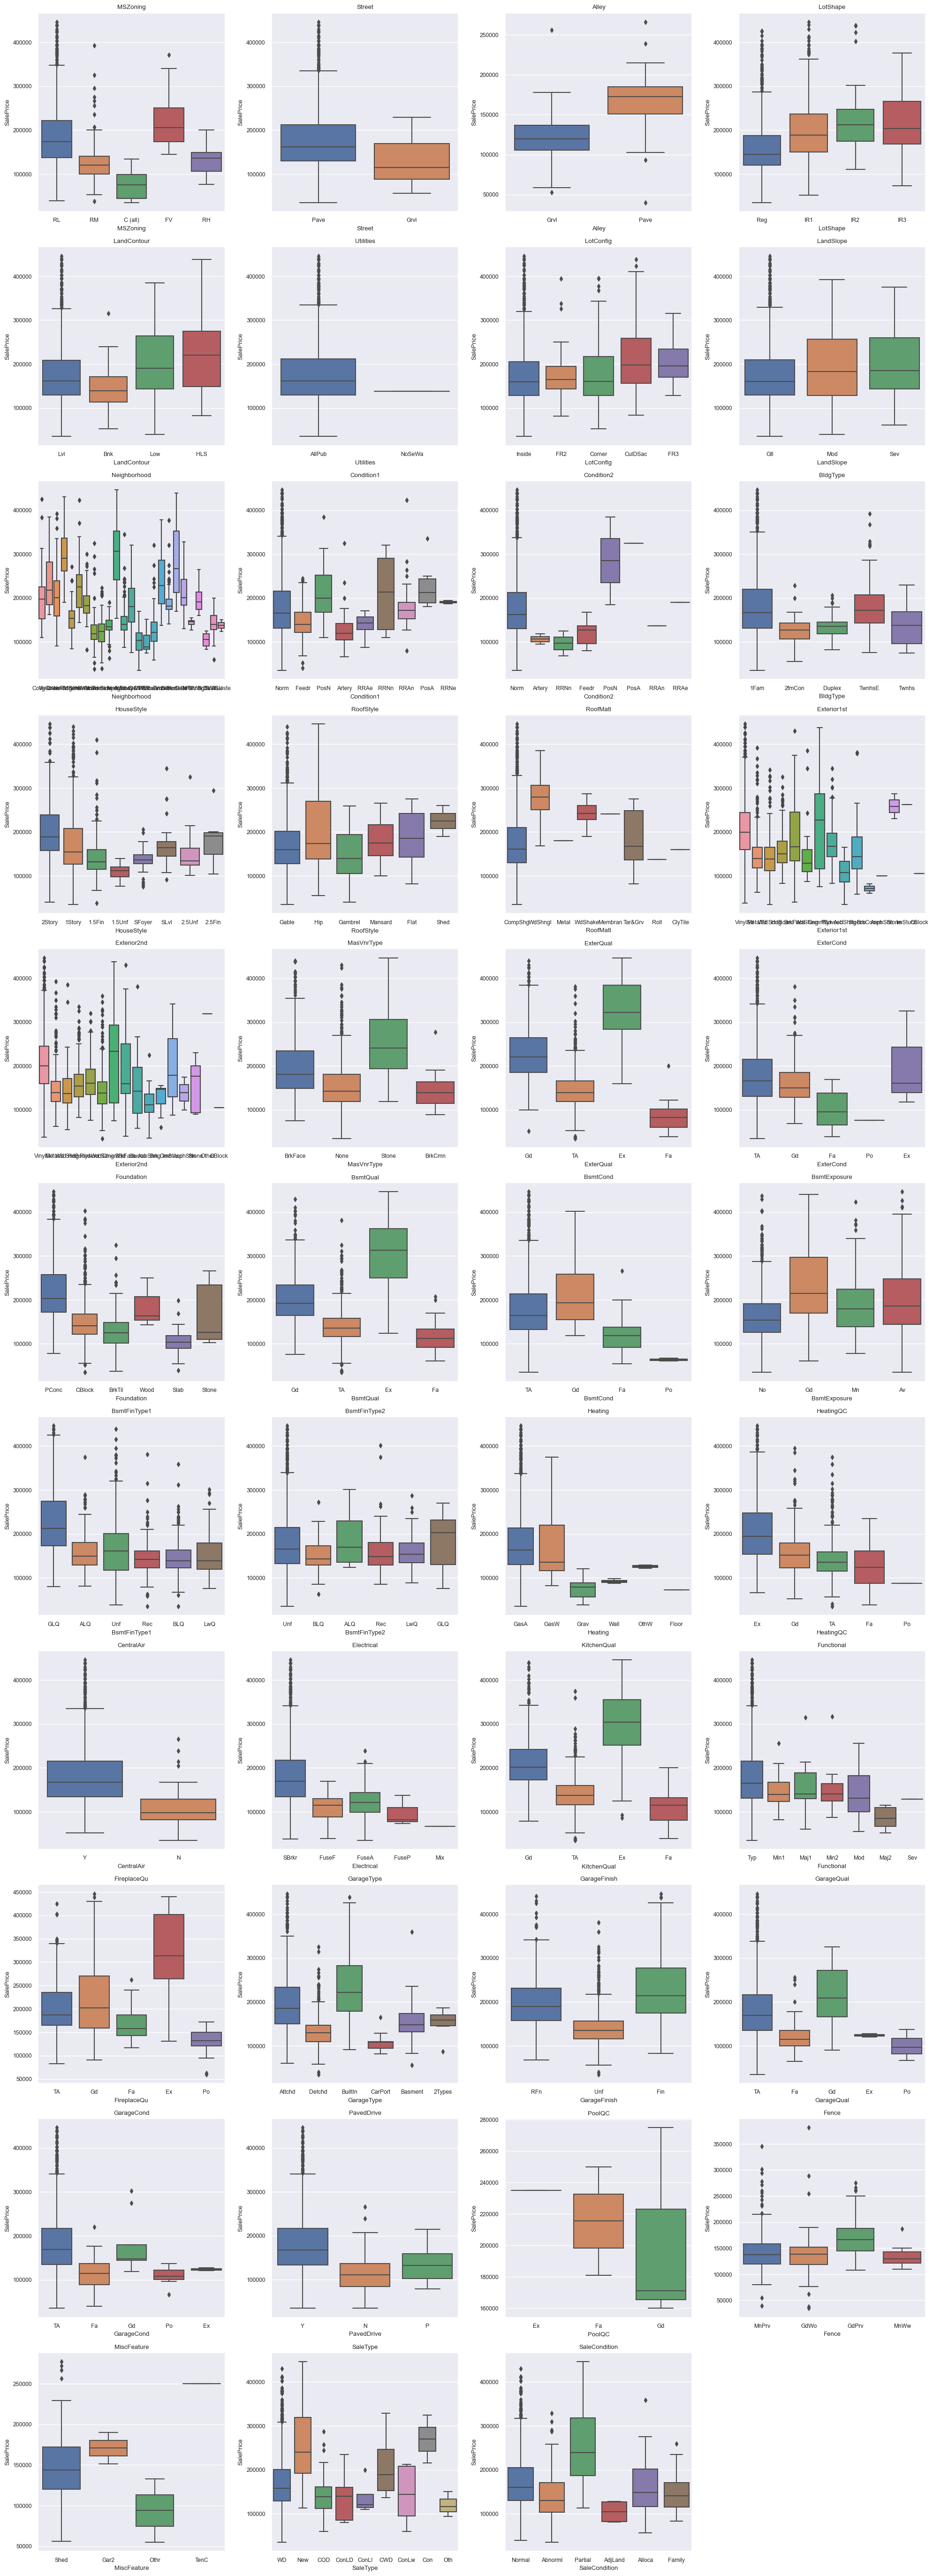

In [474]:
# Split categorical features and target variable
df_cat = train_df.select_dtypes(include=['object'])
df_cat_saleprice = pd.concat([df_cat, y], axis=1)

# Create grid of subplots
num_plots = len(df_cat_saleprice.columns) - 1
num_rows = int(np.ceil(num_plots / 4))
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))
axes = axes.reshape(-1)

# Iterate over subplots and plot each graph
for i, col in enumerate(list(df_cat_saleprice.columns[0:-1])):
    sns.boxplot(x=col, y='SalePrice', data=df_cat_saleprice, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_plots, num_rows * 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [475]:
# print(train_df['LotFrontage'].describe())
# sns.histplot(train_df['LotFrontage'])
# plt.show()

## Fill N/A

In [476]:
# Observe the missing values

#train set
train_na_count = train_df.isna().sum().sort_values(ascending= False)
train_na_count = train_na_count[train_na_count > 0]
print(train_na_count)

print('----------------------------------------------')

#test set
test_na_count = test_df.isna().sum().sort_values(ascending= False)
test_na_count = test_na_count[test_na_count > 0]
print(test_na_count)



PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
----------------------------------------------
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF       

<Axes: >

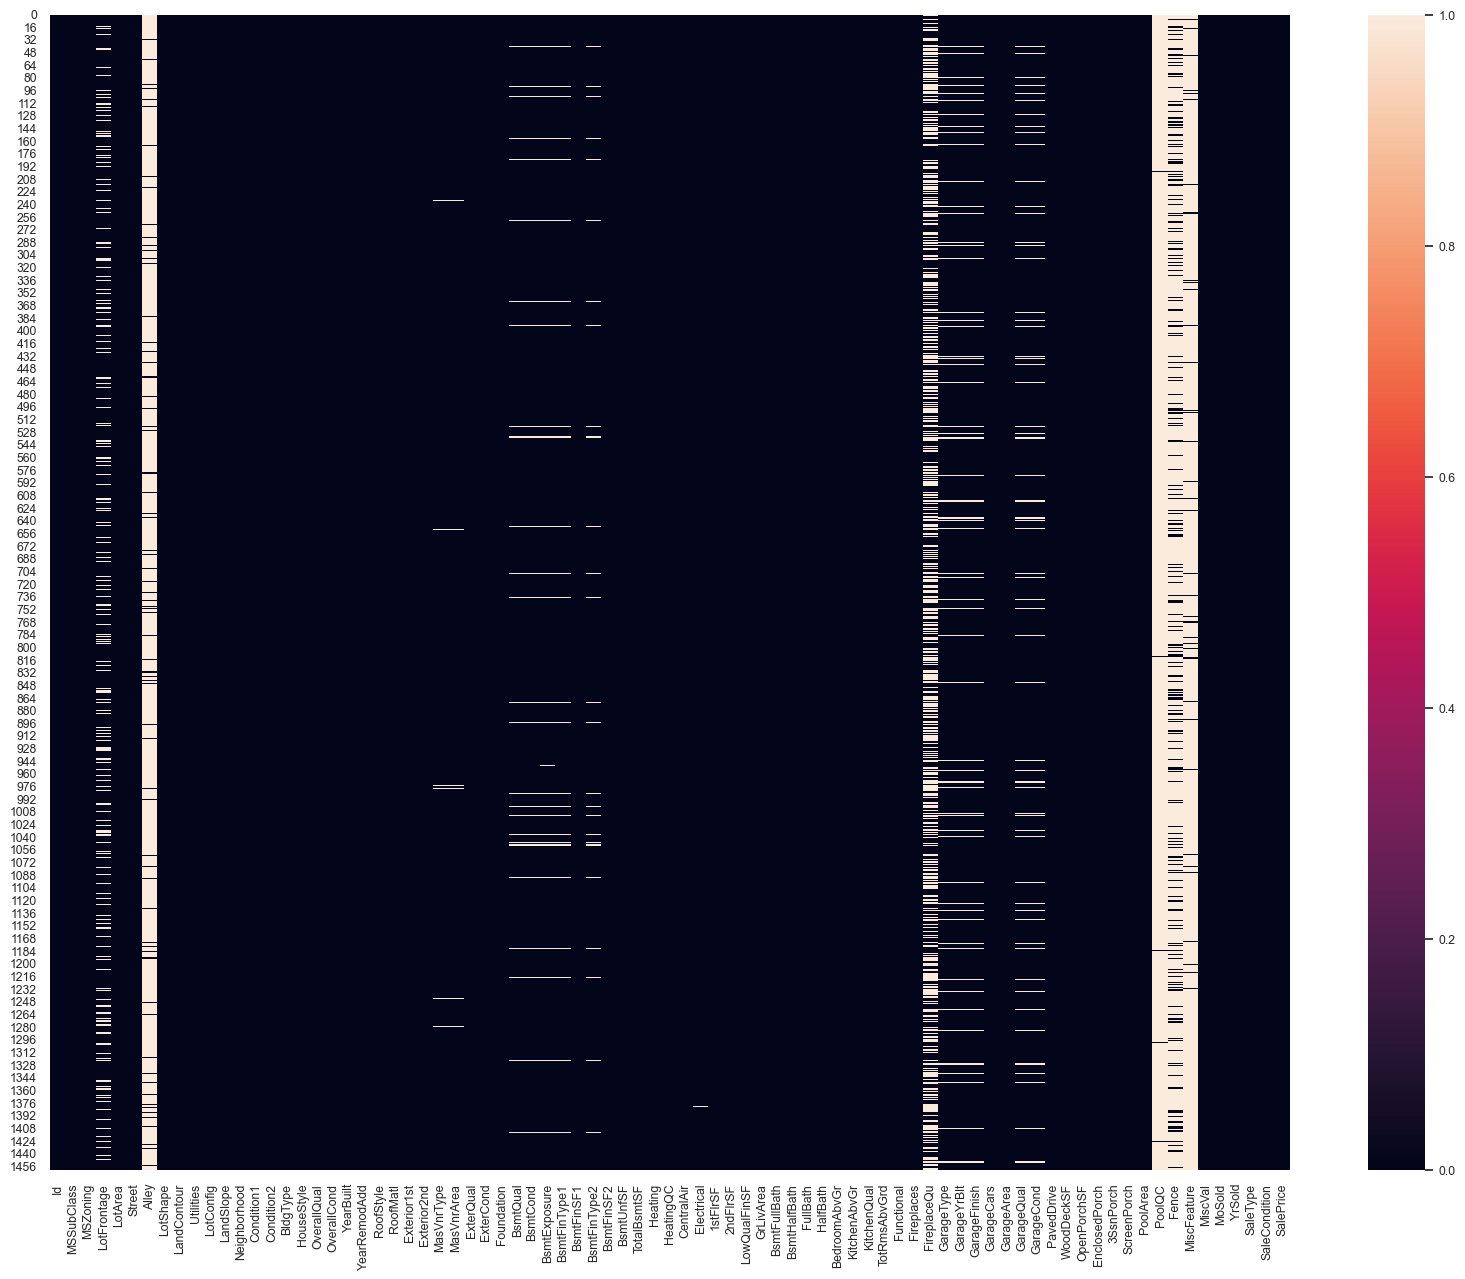

In [477]:
# Display NA pattern
plt.figure(figsize= (20,15))
sns.heatmap(train_df.isnull())

In [478]:
# Define a function to replace missing value 
def fill_na_with(col=None, col_list=[], fill_with=None, fill_method= None):
    '''
    Fill missing value
    
    Parameters:
    
        col: string, default=None
            enter the column name which needs to be filled

        col_list= list, default=[] 
            enter the column list which needs to be filled

        fill_with: string, float, int, bool, default=None
            enter the objects to fill the n/a 

        fill_method: 'mean', default=None
            enter the fill method
    Return: 
        None
    
    ''' 
    
    if col is None: # if col has nothing then process col_list
        
        if fill_method == None: # if fill_method has nothing then process fill_with
            train_df[col_list] = train_df[col_list].fillna(fill_with)
            test_df[col_list] = test_df[col_list].fillna(fill_with)
            
        else: # else process fill_method with agg function
            train_df[col_list] = train_df[col_list].fillna(train_df[col_list].agg(fill_method))
            test_df[col_list] = test_df[col_list].fillna(test_df[col_list].agg(fill_method))
            
    else:
        if fill_method is None:
            train_df[col].fillna(fill_with, inplace=True)
            test_df[col].fillna(fill_with, inplace=True)
        else:
            train_df[col].fillna(train_df[col].agg(fill_method), inplace=True)
            test_df[col].fillna(test_df[col].agg(fill_method), inplace=True)

    return

In [479]:
#fill missing value using self-defined function, starting with the NA in train_df

# fill with 0
fill_na_with(col='LotFrontage', fill_with= 0)

# fill with mean
fill_mean_list = ['GarageYrBlt', 'MasVnrArea']
fill_na_with(col_list=fill_mean_list, fill_method='mean')

# fill with 'none'
misc_list= ['PoolQC', 'Fence', 'MiscFeature','FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond']
fill_na_with(col_list=misc_list, fill_with= 'none')

# fill with 'unknown'
bsmt_col_fillna= ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Electrical', 'Alley']
fill_na_with(col_list=bsmt_col_fillna, fill_with= 'unknown')



In [480]:
# look again to check if the train_df is all good
train_na_count = train_df.isna().sum().sort_values(ascending= False)
train_na_count = train_na_count[train_na_count > 0]
print(train_na_count)

print('----------------------------------------------')

# now, look at the test_df to see what we have not covered
test_na_count = test_df.isna().sum().sort_values(ascending= False)
test_na_count = test_na_count[test_na_count > 0]
print(test_na_count)

Series([], dtype: int64)
----------------------------------------------
MSZoning        4
BsmtFullBath    2
BsmtHalfBath    2
Functional      2
Utilities       2
Exterior2nd     1
BsmtFinSF2      1
GarageArea      1
BsmtFinSF1      1
GarageCars      1
TotalBsmtSF     1
BsmtUnfSF       1
Exterior1st     1
SaleType        1
KitchenQual     1
dtype: int64


In [481]:
# fill the rest of missing value with 'none
fill_test_list= ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'GarageArea', 'BsmtFinSF1', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF']
fill_na_with(col_list=fill_test_list, fill_with= 0)

# fill the rest of missing value with mode
fill_test_list= ['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'SaleType', 'Exterior1st', 'KitchenQual']
test_df.fillna(test_df[fill_test_list].mode().iloc[0], inplace=True)

# verify the NA is gone
test_na_count = test_df.isna().sum().sort_values(ascending= False)
test_na_count = test_na_count[test_na_count > 0]
print(test_na_count)

Series([], dtype: int64)


### Feature Engineering

In [482]:
# Sum Total Area in SF
train_df['Total_SF'] = train_df['TotalBsmtSF']+train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['LowQualFinSF']
test_df['Total_SF'] = test_df['TotalBsmtSF']+test_df['1stFlrSF']+test_df['2ndFlrSF']+test_df['LowQualFinSF']

#Sum Total Bsmt Bath
train_df['Total_Bsmt_Bath'] = train_df['BsmtFullBath']+train_df['BsmtHalfBath']*0.5
test_df['Total_Bsmt_Bath'] = test_df['BsmtFullBath']+test_df['BsmtHalfBath']*0.5

#Sum Total Above Ground Bath
train_df['Total_AG_Bath'] = train_df['FullBath']+train_df['HalfBath']*0.5
test_df['Total_AG_Bath'] = test_df['FullBath']+test_df['HalfBath']*0.5

#Sum Total Property Bath
train_df['Total_Bath'] = train_df['Total_Bsmt_Bath']+train_df['Total_AG_Bath']
test_df['Total_Bath'] = test_df['Total_Bsmt_Bath']+test_df['Total_AG_Bath']

#Sum Total Porch
train_df['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch']+train_df['3SsnPorch']+train_df['ScreenPorch']+train_df['WoodDeckSF']
test_df['TotalPorchSF'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch']+test_df['3SsnPorch']+test_df['ScreenPorch']+test_df['WoodDeckSF']


#Sum Total Lot
train_df['Total_Lot'] = train_df['LotFrontage'] + train_df['LotArea']
test_df['Total_Lot'] = test_df['LotFrontage'] + test_df['LotArea']

# Categorize House Type
total_sf_range= [0, 720, 2000, 3000, 4400, np.inf]# split the data into groups according to their relationship toward target variable
total_sf_type= ['tiny', 'small', 'standard', 'large', 'extra_large' ] #group names
train_df['House_size']= pd.cut(train_df['Total_SF'], bins= total_sf_range, labels= total_sf_type).astype(str)
test_df['House_size']= pd.cut(test_df['Total_SF'],  bins= total_sf_range, labels= total_sf_type).astype(str)



In [453]:
# train_df[train_df['SalePrice']> 450000].select_dtypes(include= ['int64', 'float']).mean()

In [454]:
# train_df[train_df['SalePrice']< 450000].select_dtypes(include= ['int64', 'float']).mean()

In [483]:
# test_df['House_size']

0          small
1       standard
2       standard
3       standard
4       standard
          ...   
1454       small
1455       small
1456    standard
1457       small
1458    standard
Name: House_size, Length: 1459, dtype: object

### Get Dummies

In [484]:
# Remove Outliers
# train_df= train_df[train_df['SalePrice']< 450000]

In [485]:
# String Get Dummies
train_object_cols= train_df.select_dtypes(include=['object'])
test_object_cols= test_df.select_dtypes(include=['object'])

#Dummies
train_dummy_cols= pd.get_dummies(train_object_cols, prefix_sep='-')
test_dummy_cols= pd.get_dummies(test_object_cols, prefix_sep='-')

#Concat Dummies and drop original data 
train_df=pd.concat([train_df, train_dummy_cols], axis=1)
train_df= train_df.drop(train_object_cols.columns, axis=1)

test_df=pd.concat([test_df, test_dummy_cols], axis=1)
test_df= test_df.drop(test_object_cols.columns, axis=1)

#Remove ID Col
drop_list= ['Id']
train_df.drop(columns=drop_list)
test_df.drop(columns=drop_list)


#Create Target Variable:y
y = train_df['SalePrice']

#Remove Target Variable From Train Set
train_df= train_df.drop(columns= 'SalePrice', axis=1)



In [486]:
test_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition-AdjLand,SaleCondition-Alloca,SaleCondition-Family,SaleCondition-Normal,SaleCondition-Partial,House_size-extra_large,House_size-large,House_size-small,House_size-standard,House_size-tiny
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,1,0,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0,0,0,0,0,0,0,1,0,0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0,0,0,0,0,0,0,0,1,0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0,0,0,1,0,0,0,1,0,0


In [487]:
# Check the shape for both of our dataframe
print(train_df.shape)
print(test_df.shape)

# identify the col not discoverd in test_df
diff_cols = list(set(train_df.columns) - set(test_df.columns))
print(diff_cols) 

# remove the non-repeating col
train_df.drop(columns= diff_cols, axis= 1, inplace= True )

# check the shape again to ensure the share are consistant
print(train_df.shape)
print(test_df.shape)


feature_list= train_df.columns

(1460, 316)
(1459, 297)
['Exterior1st-ImStucc', 'Electrical-Mix', 'RoofMatl-ClyTile', 'Condition2-RRAn', 'Heating-OthW', 'Condition2-RRNn', 'Electrical-unknown', 'Exterior2nd-Other', 'Condition2-RRAe', 'RoofMatl-Membran', 'PoolQC-Fa', 'HouseStyle-2.5Fin', 'Exterior1st-Stone', 'Heating-Floor', 'RoofMatl-Metal', 'MiscFeature-TenC', 'Utilities-NoSeWa', 'GarageQual-Ex', 'RoofMatl-Roll']
(1460, 297)
(1459, 297)


### Scaling 

In [488]:
# train_df = StandardScaler().fit_transform(train_df)

# As shown in earlier visualization, the data is skewed. Thus, using RobustScaler will be more appopreate than StandardScaler
train_df = RobustScaler().fit_transform(train_df)
test_df = RobustScaler().fit_transform(test_df)


## Train Test Split

In [489]:
x_train, x_test, y_train, y_test= train_test_split(train_df, y, test_size=0.2, random_state= 0)


# ML

In [490]:
results_df= pd.DataFrame(columns=['Model', 'MAE', 'MSE','RMSE', 'R2'])

### Linear Regression

In [491]:
%%time
lr_reg= LinearRegression()
lr_reg.fit(x_train, y_train)
y_pred= lr_reg.predict(x_test)

                     
print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))

MAE: 275899588.76761156
MSE: 1.6354322031212728e+19
RMSE: 4044047728.6022143
R^2: -2368183802.074046
CPU times: user 324 ms, sys: 58.5 ms, total: 382 ms
Wall time: 92.5 ms


In [492]:
lr_param_grid= {
    'fit_intercept': [True, False],
    'positive': [True, False]
 
}
lr_gscv= GridSearchCV(lr_reg, param_grid=lr_param_grid , cv=5, scoring='r2' , n_jobs=-1)
lr_gscv.fit(x_train, y_train)
print(lr_gscv.best_params_, lr_gscv.best_score_)

{'fit_intercept': True, 'positive': False} -479994326471.3915


In [493]:
l1_reg= LinearRegression(
    fit_intercept=lr_gscv.best_params_["fit_intercept"],
    positive= lr_gscv.best_params_["positive"]
)
l1_reg.fit(x_train,y_train)
y_pred= l1_reg.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'Linear Regression',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)

MAE: 275899588.76761156
MSE: 1.6354322031212728e+19
RMSE: 4044047728.6022143
R^2: -2368183802.074046


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09


### Lasso

In [494]:
%%time
l1_reg= Lasso(max_iter= 40000,random_state=0)
l1_reg.fit(x_train, y_train)
y_pred= l1_reg.predict(x_test)

print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))

MAE: 22784.6830643185
MSE: 3633653817.6609573
RMSE: 60279.79609836912
R^2: 0.47382960293067244
CPU times: user 48.2 s, sys: 7.91 s, total: 56.1 s
Wall time: 24.7 s


/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.536e+10, tolerance: 7.191e+08



In [495]:
%%time
l1_param_grid= {
    "alpha": [10, 50, 250], 
    "tol": [0.01, 0.001], 
    "selection": ['cyclic', 'random']
 
}
 
l1_gscv= GridSearchCV(l1_reg, param_grid=l1_param_grid , cv=5, scoring='r2' , n_jobs=-1)
l1_gscv.fit(x_train, y_train)
print(l1_gscv.best_params_, l1_gscv.best_score_)

{'alpha': 50, 'selection': 'cyclic', 'tol': 0.001} 0.8831570101311407
CPU times: user 1.23 s, sys: 327 ms, total: 1.56 s
Wall time: 3.09 s


In [496]:
%%time
l1_reg= Lasso(
    alpha=l1_gscv.best_params_["alpha"],
    selection= l1_gscv.best_params_["selection"],
    tol=l1_gscv.best_params_["tol"]
)
l1_reg.fit(x_train,y_train)
y_pred= l1_reg.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'Lasso',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)

MAE: 19668.89962050273
MSE: 2590201363.215077
RMSE: 50894.020898481554
R^2: 0.6249264932316245
CPU times: user 932 ms, sys: 274 ms, total: 1.21 s
Wall time: 291 ms


/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.975e+10, tolerance: 7.191e+09



,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.249000e-01


### Ridge

In [497]:
%%time
l2_reg= Ridge(max_iter=1000000)
l2_reg.fit(x_train, y_train)
y_pred= l2_reg.predict(x_test)

print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))


MAE: 21255.418278242105
MSE: 2486888402.8397675
RMSE: 49868.711662121044
R^2: 0.639886702462034
CPU times: user 50.2 ms, sys: 35 ms, total: 85.2 ms
Wall time: 30.2 ms


In [498]:
%%time
l2_param_grid= {
    "alpha": [0.1, 1, 10, 100 ], 
    "tol": [0.1, 0.001, 0.0001], 
    "solver": ['auto', 'svd', 'lsqr']
 
}
  
l2_gscv= GridSearchCV(l2_reg, param_grid=l2_param_grid , cv=5, scoring='r2' , n_jobs=-1)
l2_gscv.fit(x_train, y_train)
print(l2_gscv.best_params_, l2_gscv.best_score_)

{'alpha': 10, 'solver': 'svd', 'tol': 0.1} 0.8789443113824735
CPU times: user 636 ms, sys: 92.4 ms, total: 728 ms
Wall time: 1.16 s


In [499]:
%%time
l2_reg= Ridge(
    alpha=l2_gscv.best_params_["alpha"],
    solver= l2_gscv.best_params_["solver"],
    tol=l2_gscv.best_params_["tol"]
)
l2_reg.fit(x_train,y_train)
y_pred= l2_reg.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'Ridge',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)

MAE: 19129.196482998927
MSE: 1966800818.758562
RMSE: 44348.628149679695
R^2: 0.7151978642729826
CPU times: user 403 ms, sys: 73.7 ms, total: 477 ms
Wall time: 115 ms


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.249000e-01
2,Ridge,1.912920e+04,1.966801e+09,4.434863e+04,7.152000e-01


### Elastic Net

In [500]:
%%time
EN_reg= ElasticNet(max_iter= 40000, random_state=0)
EN_reg.fit(x_train, y_train)
y_pred= EN_reg.predict(x_test)

print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))


MAE: 21382.934800649244
MSE: 2087014105.2942395
RMSE: 45683.84950170289
R^2: 0.6977904072383982
CPU times: user 113 ms, sys: 42 ms, total: 155 ms
Wall time: 51.1 ms


In [501]:
%%time
EN_param_grid= {
    "alpha": [0.1, 1, 10], 
    "tol": [ 0.01, 0.001, 0.0001], 
    "l1_ratio": [0.4, 0.3, 0.2]
 
}

EN_gscv= GridSearchCV(EN_reg, param_grid=EN_param_grid , cv=5, scoring='r2' , n_jobs=-1)
EN_gscv.fit(x_train, y_train)
print(EN_gscv.best_params_, EN_gscv.best_score_)


{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001} 0.87477096075589
CPU times: user 1.12 s, sys: 294 ms, total: 1.41 s
Wall time: 1.65 s


In [502]:
%%time
EN_reg= ElasticNet(
    alpha=EN_gscv.best_params_["alpha"],
    l1_ratio= EN_gscv.best_params_["l1_ratio"],
    tol=EN_gscv.best_params_["tol"], 
    random_state=0,
    max_iter= 40000
)
EN_reg.fit(x_train, y_train)
y_pred= EN_reg.predict(x_test)


mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'ElasticNet',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(2)


MAE: 19082.31073579758
MSE: 1996005615.9942992
RMSE: 44676.67865894128
R^2: 0.7109688703927266
CPU times: user 903 ms, sys: 270 ms, total: 1.17 s
Wall time: 266 ms


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.200000e-01
2,Ridge,1.912920e+04,1.966801e+09,4.434863e+04,7.200000e-01
3,ElasticNet,1.908231e+04,1.996006e+09,4.467668e+04,7.100000e-01


### XGB

In [503]:
%%time

xgb_reg= xgb.XGBRegressor(random_state=0)
xgb_reg.fit(x_train,y_train)
y_pred= xgb_reg.predict(x_test)


print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))

MAE: 18601.711659888697
MSE: 1396457388.3818045
RMSE: 37369.20374294594
R^2: 0.7977863122337183
CPU times: user 3.11 s, sys: 377 ms, total: 3.49 s
Wall time: 545 ms


In [504]:
%%time
xgb_param_grid= {
    "max_depth": [4, 5, 6], 
    "n_estimators": [100, 150, 200], 
    'learning_rate':[0.1, 0.05 ],#, 0.01, 0.05
    "gamma": [ 0, 0.1],
    "min_child_weight": [0.8, 1],
    "max_leaves": [ 3, 4, 5],
 
}

xgb_gscv= GridSearchCV(xgb_reg, param_grid=xgb_param_grid , cv=5, scoring='r2' , n_jobs=-1)
xgb_gscv.fit(x_train, y_train)
print(xgb_gscv.best_params_, xgb_gscv.best_score_)


{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'max_leaves': 3, 'min_child_weight': 0.8, 'n_estimators': 100} 0.877955209450489
CPU times: user 6.74 s, sys: 810 ms, total: 7.55 s
Wall time: 4min 57s


In [505]:
%%time
xgb_reg= xgb.XGBRegressor(
    max_depth=xgb_gscv.best_params_["max_depth"],
    n_estimators= xgb_gscv.best_params_["n_estimators"],
    learning_rate= xgb_gscv.best_params_["learning_rate"],
    gamma=xgb_gscv.best_params_["gamma"] ,
    min_child_weight=xgb_gscv.best_params_["min_child_weight"] ,
    max_leaves=xgb_gscv.best_params_["max_leaves"] ,
    random_state=0
)
xgb_reg.fit(x_train,y_train)
y_pred= xgb_reg.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'XGBoost',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)

MAE: 16781.739565496577
MSE: 1026572550.4044168
RMSE: 32040.170886005224
R^2: 0.8513474002830382
CPU times: user 3.27 s, sys: 458 ms, total: 3.73 s
Wall time: 728 ms


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.249000e-01
2,Ridge,1.912920e+04,1.966801e+09,4.434863e+04,7.152000e-01
3,ElasticNet,1.908231e+04,1.996006e+09,4.467668e+04,7.110000e-01
4,XGBoost,1.678174e+04,1.026573e+09,3.204017e+04,8.513000e-01


### LGBM

In [506]:
%%time

lgbm_reg = LGBMRegressor(random_state=0)
lgbm_reg.fit(x_train,y_train)
y_pred= lgbm_reg.predict(x_test)

print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))

MAE: 17814.456943183228
MSE: 1127219088.5955608
RMSE: 33574.08358534244
R^2: 0.8367733016976708
CPU times: user 4.2 s, sys: 1.15 s, total: 5.35 s
Wall time: 1.68 s


In [507]:
%%time

lgbm_param_grid= {
    "max_depth": [4, 6, 8], 
    "n_estimators": [100, 400,800], 
    'learning_rate':[0.1, 0.01],
    'boosting_type':['gbdt', 'dart'],
    'num_leaves':[5,10,15],
    'min_child_samples': [20, 25, 30] ,
    'subsample': [0.6, 0.8]
    
}
  
lgbm_gscv= GridSearchCV(lgbm_reg, param_grid=lgbm_param_grid , cv=5, scoring='r2', n_jobs=-1)
lgbm_gscv.fit(x_train, y_train)
print(lgbm_gscv.best_params_, lgbm_gscv.best_score_)


{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 30, 'n_estimators': 800, 'num_leaves': 5, 'subsample': 0.6} 0.8892119682033043
CPU times: user 27.9 s, sys: 5.94 s, total: 33.9 s
Wall time: 3min 55s


In [508]:
%%time
lgbm_reg= LGBMRegressor(
    max_depth=lgbm_gscv.best_params_["max_depth"],
    n_estimators= lgbm_gscv.best_params_["n_estimators"],
    learning_rate= lgbm_gscv.best_params_["learning_rate"],
    boosting_type= lgbm_gscv.best_params_["boosting_type"],
    num_leaves= lgbm_gscv.best_params_["num_leaves"],
    min_child_samples= lgbm_gscv.best_params_["min_child_samples"],
    subsample=lgbm_gscv.best_params_["subsample"]
)
lgbm_reg.fit(x_train,y_train)
y_pred= lgbm_reg.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'LGBM',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)



MAE: 16529.02449052239
MSE: 1002389755.0023689
RMSE: 31660.539398474702
R^2: 0.8548491843542387
CPU times: user 20.2 s, sys: 4.86 s, total: 25 s
Wall time: 7.48 s


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.249000e-01
2,Ridge,1.912920e+04,1.966801e+09,4.434863e+04,7.152000e-01
3,ElasticNet,1.908231e+04,1.996006e+09,4.467668e+04,7.110000e-01
4,XGBoost,1.678174e+04,1.026573e+09,3.204017e+04,8.513000e-01
5,LGBM,1.652902e+04,1.002390e+09,3.166054e+04,8.548000e-01


### SVM

In [509]:
%%time 

SVRegressor= SVR()
SVRegressor.fit(x_train, y_train)
y_pred= SVRegressor.predict(x_test)

print('MAE:', MAE(y_test, y_pred))
print('MSE:', MSE(y_test, y_pred))
print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
print('R^2:',r2_score(y_test, y_pred))


MAE: 55554.60838460215
MSE: 7243087936.932941
RMSE: 85106.33311882813
R^2: -0.048833666339004544
CPU times: user 616 ms, sys: 192 ms, total: 808 ms
Wall time: 243 ms


In [510]:
%%time
SVM_param_grid= {
    'kernel': ['linear'],
    'tol':[0.001, 0.0001], 
    'epsilon': [0.1, 0.01, 0.001],
    'C':[1, 10],
    'gamma': ['scale', 'auto']

}
  
SVM_gscv= GridSearchCV(SVRegressor, param_grid=SVM_param_grid , cv=5, scoring='r2' , n_jobs=-1)
SVM_gscv.fit(x_train, y_train)
print(SVM_gscv.best_params_, SVM_gscv.best_score_)

{'C': 10, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001} 0.594781603196243
CPU times: user 360 ms, sys: 28.8 ms, total: 389 ms
Wall time: 3.04 s


In [511]:
%%time
SVRegressor= SVR(
    kernel=SVM_gscv.best_params_["kernel"],
    tol= SVM_gscv.best_params_["tol"],
    epsilon=SVM_gscv.best_params_["epsilon"],
    C=SVM_gscv.best_params_["C"],
    gamma=SVM_gscv.best_params_["gamma"],
    )
SVRegressor.fit(x_train,y_train)
y_pred= SVRegressor.predict(x_test)

mae= MAE(y_test, y_pred)
mse= MSE(y_test, y_pred)
rmse= np.sqrt(MSE(y_test, y_pred))
r2= r2_score(y_test, y_pred)
    
results_df=results_df.append({
        'Model': 'Support Vector Regression',      
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    },
         ignore_index=True)
                      
print('MAE:', mae)
print('MSE:',mse)
print('RMSE:',rmse)
print('R^2:',r2)

results_df.round(4)



MAE: 28260.3424039922
MSE: 2954079248.315188
RMSE: 54351.44200768907
R^2: 0.5722352405984499
CPU times: user 220 ms, sys: 8.56 ms, total: 229 ms
Wall time: 240 ms


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.758996e+08,1.635432e+19,4.044048e+09,-2.368184e+09
1,Lasso,1.966890e+04,2.590201e+09,5.089402e+04,6.249000e-01
2,Ridge,1.912920e+04,1.966801e+09,4.434863e+04,7.152000e-01
3,ElasticNet,1.908231e+04,1.996006e+09,4.467668e+04,7.110000e-01
4,XGBoost,1.678174e+04,1.026573e+09,3.204017e+04,8.513000e-01
5,LGBM,1.652902e+04,1.002390e+09,3.166054e+04,8.548000e-01
6,Support Vector Regression,2.826034e+04,2.954079e+09,5.435144e+04,5.722000e-01


### MLP

In [512]:
# %%time 

# MLP= MLPRegressor(max_iter= 2000)
# MLP.fit(x_train, y_train)
# y_pred= MLP.predict(x_test)


# print('MAE:', MAE(y_test, y_pred))
# print('MSE:', MSE(y_test, y_pred))
# print('RMSE:',np.sqrt(MSE(y_test, y_pred)))
# print('R^2:',r2_score(y_test, y_pred))


In [513]:
# %%time
# MLP_param_grid= {
#     "hidden_layer_sizes": [(100,60), (300,200), (1000,600)], 
#     "activation": ['logistic', 'relu', 'tanh'], 
#     'learning_rate':['constant', 'invscaling', 'adaptive'],
#     'solver': ['sgd', 'adam', 'lbfgs'], 
#     'alpha': [0.001,0.0001, 0.00001]
# }

# MLP_gscv= GridSearchCV(MLP, param_grid=MLP_param_grid , cv=5, scoring='neg_root_mean_squared_error' , n_jobs=-1)
# MLP_gscv.fit(x_train, y_train)
# print(MLP_gscv.best_params_, MLP_gscv.best_score_)

## Export Predited Data 

In [514]:
pred_df= pd.DataFrame()
pred_df['Id']= test_id
pred_df['SalePrice'] = xgb_reg.predict(test_df)

pred_df.to_csv('xgb_pred_price.csv', index= False)
pred_df

,Id,SalePrice
0,1461,131127.843750
1,1462,180108.890625
2,1463,186359.125000
3,1464,186258.906250
4,1465,194960.718750
...,...,...
1454,2915,93257.789062
1455,2916,102019.109375
1456,2917,165520.796875
1457,2918,112103.078125


In [515]:
pred_df= pd.DataFrame()
pred_df['Id']= test_id
pred_df['SalePrice'] = lgbm_reg.predict(test_df)

pred_df.to_csv('lgbm_pred_price.csv', index= False)
pred_df

,Id,SalePrice
0,1461,125407.459126
1,1462,176097.366041
2,1463,190247.300924
3,1464,192698.652565
4,1465,184979.761943
...,...,...
1454,2915,92500.855361
1455,2916,94728.201121
1456,2917,174188.413985
1457,2918,129699.084409


In [516]:
import eli5
from eli5.sklearn import PermutationImportance

feat_permut = PermutationImportance(xgb_reg, random_state=0).fit(x_test, y_test)
eli5.show_weights(feat_permut, feature_names=list(feature_list))




Weight,Feature
0.3941 ± 0.0583,Total_SF
0.1222 ± 0.0406,OverallQual
0.0241 ± 0.0016,2ndFlrSF
0.0213 ± 0.0122,BsmtQual-Ex
0.0147 ± 0.0154,LotArea
0.0109 ± 0.0046,YearRemodAdd
0.0106 ± 0.0032,YearBuilt
0.0103 ± 0.0045,BsmtUnfSF
0.0071 ± 0.0042,Total_Bath
0.0059 ± 0.0022,BsmtFinSF1


/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



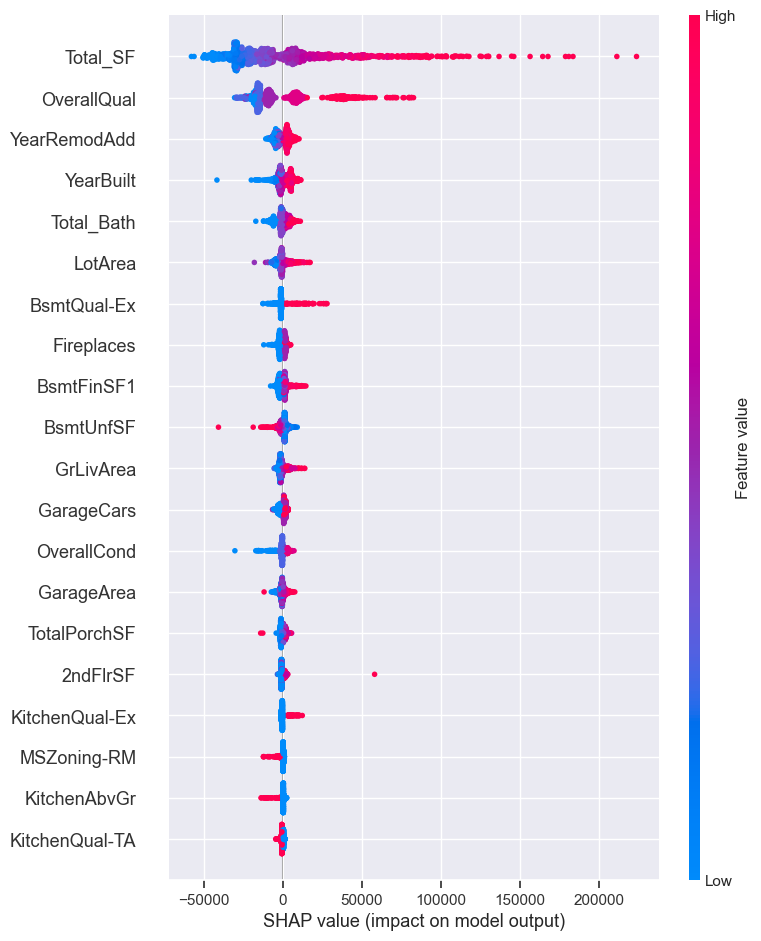

In [517]:
explainer= shap.Explainer(xgb_reg)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train, feature_names=feature_list)


Text(0, 0.5, 'Predicted')

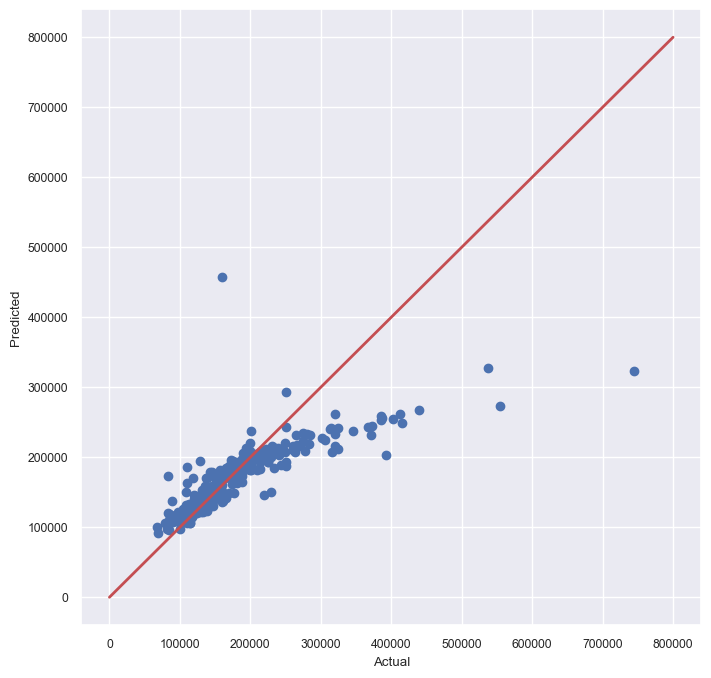

In [518]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot([0, 800000], [0, 800000], color='r', linestyle='-', linewidth=2)
# plt.xlim([y_test.min(), y_test.max()])
# plt.ylim([y_pred.min(), y_pred.max()])
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [448]:
fig = px.box(train_df['Total_SF'])
fig.update_layout(xaxis_title='', yaxis_title='Price', title='Identify Outliers Using Box Plot')

# Show the plot
fig.show()

In [449]:
train_df['House_size']=df['Total_SF']

NameError: name 'df' is not defined

In [465]:
x_train

array([[-0.98494182,  0.        , -0.32653061, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86173854, -0.6       , -1.71428571, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8275154 , -0.6       ,  0.10884354, ...,  1.        ,
        -1.        ,  0.        ],
       ...,
       [ 0.68514716,  1.4       ,  0.05442177, ...,  0.        ,
        -1.        ,  0.        ],
       [-0.22655715, -0.4       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [-0.05407255, -0.6       , -0.08163265, ...,  0.        ,
         0.        ,  0.        ]])